# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [30]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [31]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [32]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")

    X_quant_features = toxic_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [33]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='data/toxiccomments_train.csv', my_random_seed=70)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [34]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 12994, 'Neg': 114662, 'TP': 6582, 'TN': 57404, 'FP': 57258, 'FN': 6412, 'Accuracy': 0.5012377013223037, 'Precision': 0.1031015037593985, 'Recall': 0.5065414806833923, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [35]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 12994, 'Neg': 114662, 'TP': 12888, 'TN': 114576, 'FP': 86, 'FN': 106, 'Accuracy': 0.9984959578868209, 'Precision': 0.993371358100817, 'Recall': 0.9918423887948283, 'desc': 'svm_train'}


### MODEL: logistic regression

In [36]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 12994, 'Neg': 114662, 'TP': 12949, 'TN': 114598, 'FP': 64, 'FN': 45, 'Accuracy': 0.9991461427586639, 'Precision': 0.9950818412356874, 'Recall': 0.9965368631676158, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [37]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 12994, 'Neg': 114662, 'TP': 12721, 'TN': 103334, 'FP': 11328, 'FN': 273, 'Accuracy': 0.9091229554427523, 'Precision': 0.5289617031893218, 'Recall': 0.9789903032168693, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [38]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 12994, 'Neg': 114662, 'TP': 12892, 'TN': 114540, 'FP': 122, 'FN': 102, 'Accuracy': 0.998245284201291, 'Precision': 0.9906254802520362, 'Recall': 0.9921502231799292, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [39]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 12994, 'Neg': 114662, 'TP': 10956, 'TN': 114474, 'FP': 188, 'FN': 2038, 'Accuracy': 0.982562511750329, 'Precision': 0.9831299353912419, 'Recall': 0.8431583807911344, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [40]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

/Users/yujunjiang/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'Pos': 12994, 'Neg': 114662, 'TP': 0, 'TN': 114662, 'FP': 0, 'FN': 12994, 'Accuracy': 0.8982108165695306, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_train'}


/Users/yujunjiang/Desktop/Machine Learning/final_assignment_1/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


### ROC plot to compare performance of various models and fits

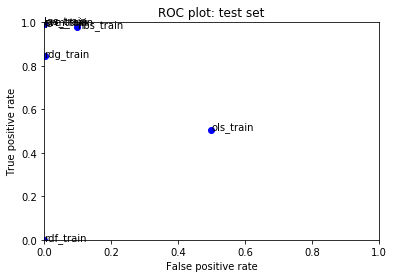

In [41]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

### let's look at some false positives:

In [42]:
ols_predictions = ols.predict(X_train)

In [43]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
111
The article does a good job of establishing the notability of its subject.
* * * * * * * * * 
221
"

I find the remarks here of great interest, and indeed raise both issues I have considered at length and those which I have never considered before.

a) Discrimination:: clear this list maybe hetergenous, but is clearly not indiscriminate. On the contrary, groups of Masons have discussed together and made certain decisions about their relations of amity with one another This is clear discriminate behaviour. As regards notability, clear the discussion about whether UGLE recognised the Rite of Memphis-Misraim in the 1850's clearly involved political decisions taking place in consequence of the Revolutions of 1848. Involving such key figures at Louis Blanc and Guiseppe Garibaldi, this is clearly highly notable people and events. And there has yet to be any serious discussion of the role of revolutionary freemasonry in the International Workingmen's Associati

2578
Please stop with your vandalizing of the Jim Clark page.
* * * * * * * * * 
2588
"

Funny take on intel editing

Found this on you tube, mentions intel wiki editing. .  talk "
* * * * * * * * * 
2600
Hello, and welcome to Wikipedia! We appreciate your contributions, but we regretfully cannot accept original research.  Please be prepared to cite a reliable source for all of your information.  Thanks for your efforts, and happy editing!    (talk • edits)
* * * * * * * * * 
2608
randomtime 

Hot Coco
The secret levels need to be added.

I know one was hot Coco, which you got by crashing into an alien sign.

 Listiness... 

Is it okay if I be bold and make the worlds not subcategories? I won't delete anything except the listiness, and the world titles will still be as big and bold.
* * * * * * * * * 
2801
(UTC)

 It's Britain, not Briton, but I would not expect a fan to be literate.88.110.112.185  14:46, 27 April 2012
* * * * * * * * * 
2827
"

 Concerning your recent revision unto Me

4957
"Corinne, I was replying to your comment that ""I think articles on animals (and birds, and insects) are much more interesting than articles on plants and fungi, but I'll do those, too. I also really like articles on geology, mining, and environmental topics."" I'm saying: that sounds fine, go ahead and do them at TFA. To see what ""support on prose"" means, click on WP:FAC and then search for that phrase. You'll see that I've offered something called ""support on prose"" for many of the articles currently up at FAC. Looking at what I've done should explain it better than I can. - Dank (push to talk) 

"
* * * * * * * * * 
4977
What the hell kind of joke is that?
* * * * * * * * * 
5004
"I am really really sorry, okay you win I promise to stop using twinkle, please guys just one more chance I'm begging you please, I am truly truly sorry —123 "
* * * * * * * * * 
5020
But i i have said b4 sweet heart you have it listed totaly wrong dates and years
and some of the songs are not even

7376
=For crying out loud
BritshWatcher and IP, mountains and molehills spring to mind.
* * * * * * * * * 
7389
As I suggested, with your frame of mind as regards this article I would if I was you simply take it off your watchlist and then it won''''t bother you anymore. Please don't turn what is a silly little article into a battlefield, I assure you it is not worth it.
* * * * * * * * * 
7393
What's the time delay in updating Wiki search parameters internally? Name etc is still showing in searches. As for conspiracy .... I keep looking at patterns - I see things - 20+years of net security and even dealing with nasty issues gives you some insight (Understatement) . As I said three in a row. I am being as circumspect as possible at this time - what is the best way to be able to speak openly about concerns and observed patterns... and where they lead?
* * * * * * * * * 
7396
"

 Questionable tactics 

The section ""Questionable tactics"" should be renamed to ""War crimes"" or ""Possible

9492
"
 The section ""#Dear Michael Bednarek"" is only for User:Michael Bednarek. Please explain why you could ignore the fact that User:Michael Bednarek couldn't have answered at all and, moreover, revert as if you were User:Michael Bednarek.
 Please explain why you cannot wait and see for a while(only 72 hours, as mentioned above). 
 Please explain why you interfered in the section for ""#Dear Michael Bednarek"".
 Apparently your vandalism reverts have no reasonable reason as well as Bednarek's, because you and Bednarek have left the 1)lead 2)unsourced, that looks like evil vandalism and cruel personal attack with bald-faced lies. Please explain why you could ignore your obvious contradictions(lies).
 Please explain why you can think that disambiguation pages without necessary important lead can be helpful as an encyclopedia(WP:5P).
 Please explain why you can think that disambiguation pages without necessary important lead can be written from a neutral point of view(WP:5P) and why y

11663
Watchmen 
How was my edit not constructive? People who see that piece of garbage movie will think that's exactly what the book is like and that isn't true at all. Please revert your edit now.
* * * * * * * * * 
11671
"

I agree that we create a new section on athletics. Please remove the athletic ""controversies"" and place them there."
* * * * * * * * * 
11715
"

 Please do not vandalize pages, as you did with this edit to Sperm Whale. If you continue to do so, you will be blocked from editing.    "
* * * * * * * * * 
11716
"

Hy 
I am a 29years old artist and I work with different media, from light to images and videos.
Sometimes I work in digital (with photoshop) over some picture I made with my camera, and sometimes I use other pictures, like scans from newspapers ec..
What I do is add colors to the images, merge other images in one ecc..
Finally the work is different from the starting image and have my personal ""cut"".
I found your images on Wikimedia and I think that the p

13964
"

 ""related groups"" info removed from infobox 

For dedicated editors of this page: The ""Related Groups"" info was removed from all  infoboxes. Comments may be left on the Ethnic groups talk page.  "
* * * * * * * * * 
13974
Notability of Night nazif
A tag has been placed on Night nazif, requesting that it be speedily deleted from Wikipedia. This has been done because the article seems to be about a person, group of people, band, club, company, or web content, but it does not indicate how or why the subject is notable, that is, why an article about that subject should be included in Wikipedia. Under the criteria for speedy deletion, articles that do not assert notability may be deleted at any time. Please see the guidelines for what is generally accepted as notable, and if you can indicate why the subject of this article is notable, you may contest the tagging. To do this, add  on the top of the page (below the existing db tag) and leave a note on the article's talk page expl

16079
"I guessed that that guy altaf was behind your previous message, and I was correct. Regarding the article, I have seen similar language used in many other wikipedia articles and so do not see why mine is such a huge problem. Since it was an edit to the first line, I don't think it would be appropriate to add more to that part of the article, as the logic behind the article is already within the rest of the article (record sales, changes. etc.) and it would look strange to discuss record sales and etc in the first line of the article, right? Anyway, since you wish for references anyway, I will do so immediately. may i please know how to add references to an article? i cannot find the ref toolbar mentioned here anywhere in the page! http://en.wikipedia.org/wiki/Help:Introduction_to_referencing/3
but I would also appreciate if you could encourage altaf to not continue making personal attacks against me, as it makes me feel highly unwelcome on this site. I say ""personal attacks"" as

18370
For your amusement, I kind of think the following would be a more neutral rewrite:

1.3)  Zephram Stark is accused of engaging in tendentious (exhibiting a strong POV) and disruptive editing with respect to the article terrorism over an extended period of time, see Talk:Terrorism/Archive_6#NPOV_solutions and Wikipedia:Requests_for_arbitration/Zephram_Stark/Evidence#ZS.27s_changes_to_Terrorism.
* * * * * * * * * 
18405
It was so sad to see the United Arab Republic collapsed because of the arrogancy of those Egyptian officers. Much would have been achieved if the United Arab Republic is still there. As an Arabic person, this is my dream to see all Arabic countries united and under one flag.
* * * * * * * * * 
18439
Thanks. 

That was unexpected...but thanks. 
why was it unexpected? 
I dunno. Just thought I would be treated like an ass or something for the edit warning. did not expect a medal... 
.....I got en edit warning, oh well. Expect the unexpected 

 ) 

Looks to me like you 

20485
other stuff that shouldn't really be on my front page.  Though I don't know why.  Doesn't matter anyway
Blah!
http://www.findarticles.com/p/articles/mi_m1132/is_n10_v48/ai_19344901
* * * * * * * * * 
20584
"

The article explains a manifestation of antisemitism; it is not, as stated above, ""a defence."" The assertion regarding ""idiotic eating practices"" is manifestly not NPOV; and, approval of other certifications, i.e., ""Certified organic, FDA approved[,] etc[.],"" shows an inconsistency that perforce implies a false premiss. talk "
* * * * * * * * * 
20591
":In response to the interwiki and internal incoming links, that is also dependent on recentism. eg, Victor Trumper, called the ""crown prince of the golden age"" because of his being regarded as the most supreme stylist of all time, and also the best batsman in the world of the era 1890-1920, one of the Six Giants of the Wisden Century, inuaugural inductee into ACHOF has only 105 incoming links and two interwiki. Mahendr

22378
"

So far nobody's reverted me so that gives me hope. Meantime, let me pick your brain on a broader related issue. In recent years, Wikipedia has likely gained in importance as a ""vetting"" tool for employers, clients and others considering doing business with someone. Naturally, the one doing the vetting has the lion's share of responsibility in judging an entry's reliability and supplementing it with other research. That said, do we bear some degree of ethical obligation to researchers to ensure an entry presents, as far as possible, an accurate, well-rounded picture of the subject? In the case of Ms. Caesar, I was concerned that universities or other organizations looking to employ her and/or give her some sort of public platform would come away with the impression that nothing about her merits further scrutiny. What are your thoughts?   "
* * * * * * * * * 
22417
Re: Katrina deaths 

I found another source. http://www.boston.com/news/nation/articles/2005/08/31/ohioans_focus_

24526
Question
May I ask you why haven't you replied until yet? As an admin it is your responsibility, don't you think?talk
* * * * * * * * * 
24673
What he dosent realise is, I DONT HAVE JUST ONE IP ADDRESS, so his block is useless, like he is.
* * * * * * * * * 
24680
"==Regarding edits made during September 12 2006==
Thank you for experimenting with Wikipedia. Your test worked, and it has been reverted or removed. Please use the sandbox for any other tests you want to do. Take a look at the welcome page if you would like to learn more about contributing to our encyclopedia. If this is an IP address, and it is shared by multiple users, ignore this warning if you did not make any unconstructive edits.  (talk) "
* * * * * * * * * 
24686
which I'm in the middle of composing
* * * * * * * * * 
24737
WP:Fringe 

Are you aware of this notice board? You might, for instance, want to ask others there to take a look at Unexplained human mutilation,
* * * * * * * * * 
24829
Any pictures of the 

26897
"Bushranger|The Bushranger]] One ping only 
 No. These non-notable recordings will need someone else to babysit them through that process. The fact that no one else commented on them is a louder statement of fact.   

 Deletions 

Have your say?  
 Jesus Freak Hideout
 Ghost Ship (band)

==The "
* * * * * * * * * 
26936
Do we really need this in the article?
* * * * * * * * * 
26991
"

DYK

Did you know? has been updated. A fact from the article Silent All These Years, which you recently created, has been featured in that section on the Main Page. If you know of another interesting fact from a recently created article, then please suggest it on the ""Did you know?"" talk page."
* * * * * * * * * 
27049
Don't tell me what I can and can't do and don't be rude. I will include it per Wikipedia guidlines, which are nothing to do with you. I do not chose how they do, I meerly change the charts per guidlines. The formats are both allowed, but not to be reverted after somebody's hard wor

29311
]] for GA status because of several issues, which are detailed on the article's talk page. If there are any comments you would like to make, or any questions you have about the failing of this article, then please forward them to my talk page. Good luck for a future candidacy. Regards, 
 |Pass = == GA Review ==

Dear ,
I am delighted to inform you that I have seen fit to pass Robin Hood for GA status, as I believe that it qualifies the criteria that is commonly accepted by the community. Further details of the articles passing, and possible further improvements to the article can be found on the articles talk page. If you have any questions about the review, please leave them on my talk page. Regards, 
 |Hold = == GA Review ==

Dear ,
I am here to inform you that I have placed Robin Hood on Hold status for a period of 2-7 days. This means that you have 2-7 days to address the issues detailed on the articles talk page. If I feel that, after this designated time, the issues raised 

31469
Just FYI
Concur. I was about to do it myself.  (talk)
* * * * * * * * * 
31520
Cka4004, the reason why Guilherme Paula provided the code for the infobox is because of this Talk:Northern_Ireland#Short_term_fix discussion. It wasn't so that we could restart the whole discussion again fron last October, the concencus is to remove all flags from the infobox, the code was provided so that we could make it into a template and then request an admin to protect that template and place it on the article so that the article itself can be unprotected so that we can edit it.
* * * * * * * * * 
31616
August 2009 (UTC)

Nothing you have written before or since has changed my opinion, in fact it has been reinforced. I am unclear as to why you persist in posting here.   09:38, 21
* * * * * * * * * 
31644
E.g., the section on Advaita Vedanta seems to rely on two citation to Sivananda and no other sources.
* * * * * * * * * 
31691
"
1. I will not even move my finger to source anything of that BS, I

33734
No need to worry about that; I got a warning that I'm on my last strike or something before I get blocked. Not like I contribute anyway.
* * * * * * * * * 
33757
Edit request from 174.3.185.61, 28 June 2010 

U MAD?!

174.3.185.61
* * * * * * * * * 
33831
"|decline=Per WP:VANDAL, vandalism applies to all namespaces, not just the Article namespace. Also, if you're so concerned about the rest of us ""getting a life,"" then why do you want to edit, anyway? Talk page protected due to repeated abuse.  t/c "
* * * * * * * * * 
33845
So... no, you won't. Good to know.
* * * * * * * * * 
33865
Awaaz soory to break it to you but that figure is about blaochistan lol not azad kashmir seems like you have been misrepresenting again..
* * * * * * * * * 
33918
Notability tag
A television series running on a major television network should be inherently notable, so I removed the tag from Chikkun Takkun
* * * * * * * * * 
33940
WRONGYT policy has been decided on policy pagesconsensus is against y

Re this message which you left on my talk page. I removed the photo because it is copyright violation and up for speedy deletion. See . The way you had added it also messed up the format of the infobox. Thumbnail coding is never used in infoboxes. The second time, I left the photo you insist on restoring but merely fixed the format . You likewise reverted that, leaving this mess. You're right about one thing: ""Vandalism and trolling will not be tolerated"". You should stop doing it and you should stop trying to evade this block. If you want to ask for page protection, you may do so at Wikipedia:Requests for page protection, although it is highly likely that this will backfire on you.   "
* * * * * * * * * 
35947
"

 Elvis' Airplanes 

From Archive #28: ""How many of the 1970s-era tours did Presley charter Big Bunny, the Playboy jet which was all black except for a white Playboy logo on the tail? Touring sound engineer Bruce Jackson talked in awe about the luxury of this method of trav

37838
"

Please stop. If you continue to vandalize pages, }} you will be blocked from editing Wikipedia.  A link to the edit I have reverted can be found here: link. If you believe this edit should not have been reverted, please contact me.  [[user talk:tellyaddict|addict]][[Wikipedia:Editor review/Tellyaddict|Editor review!]] "
* * * * * * * * * 
37848
"

""how you would classify any title given by leading newspapers as ""emotional""?""
 Here are some of the headlines from Times of India today: ""Future of Indian bowling is bleak"", ""Ranbir Kapoor is hard to please"", ""Why Indian men rape"". That doesn't mean we are going to include things like these in the intros of the articles on Indian cricket team, Ranbir Kapoor or Indian people. Facts, not opinions, should be included in the intros, plain and simple.

 ""Delhi tops the list in crimes among all states of India, followed by Maharashtra""
 You haven't read the article you linked to. Quote from the article: ""UP accounted for the 

39958
Reply
Hey, you could at least mention Jasenovac and 700 000 killed (not only serbs) but you say it's all bs, well, what is vandalism, death of innocent, or putting truth here?
* * * * * * * * * 
40123
RE:Nikola Tesla would have loved this ....
Thanks for the barnstar, I appreciate it -)  (''talk)
* * * * * * * * * 
40253
For the record I have over 35 DYKs, 4 GAs and an FA, as well as a QI on commons. I also happen to hold a fair number of permissions, and the work around that takes up a lot of my time. But I don't make a big deal about it. I think content creation (at least some) is important, a vital background to have so one knows what the issues and concerns are, as it's the main focus of the project, and we should never lose sight of it. But we don't expect the engineers and janitors at Ford to work on the assembly line every day, and we don't claim that the assembly line workers are better or worse than the janitors. Just different.

I don't proxy for banned users on WR, you

42187
It would have better context as the 2nd-to-last paragraph of Epidemiology.
* * * * * * * * * 
42189
It is impossible to number popes accurately. That is why they are not numbered in the Annuario Pontifico. Let's not mess with it here.
* * * * * * * * * 
42280
I just noticed that the comments were made a year ago. How bizarre of you to bring it up now...
* * * * * * * * * 
42497
"

 I was not actually banned in the first place. The whole thing is bogus and dishonestly contrived by Caspian blue ... which is why I will ignore it.  I only used that name to document and expose Caspian blue's abuse of the wikipedia system and the tag team editing that was going on articles like Comfort women.

 I had a username, Documentingabuse disallowed because Rlevse decided others would think it was confusingly ""official"".  I think we shall discover that was done on the basis of his own personal bias. Checkuser Rlevse cant tell the difference between an IP address in Japan and an IP in Canada ..

44377
I am so sorry for creating another account I feel like such an idiot right now. I will definitely take six months off to think about what I have done and promise never to create any more accounts ever again and hope to come back (3, Febuary 2011) and sort this out and hope to get my original account back.
* * * * * * * * * 
44413
Bob Johnson (radio) 

Listen, mate, I was about to post on his discussion page, but I was called away from my computer to do some work and haven't had the chance to discuss it until now. I shan't bother now, as all that I could have thought of saying has already been said. -
* * * * * * * * * 
44449
VBS.tv
All over the Web today people are talking about VBS.tv. Particularly as one Shane Smith managed to sneak into North Korea with a report team, photographers, the lot. It's headlining in major news outlets across the globe.

So naturally one wants to know who these people at VBS.tv are, right? And naturally one then surfs to one's favourite information s

46819
Classic Rock

Hello. I was wondering if you would like to participate in my classic rock survey. I'm trying to find the most like classic rock song. There is more information on my user page. Hope you participate!
* * * * * * * * * 
46874
Support: Recommend merge, but keep unique information.
* * * * * * * * * 
46910
Dear Kubigula ,I urge
Request the  administrator. 
It seem the debate is over on Naresh Sonee so Pls delete each and every link/ debate on him as the search engine hits on naresh sonee 'hits' first on wikipedia discussion/delation page which is giving a wrong impression on seekers , readers of Sonee's who has many hits to his credit. You can understand the negative impact such deletion page is creating. So treat it as urgent please. Regards- Alan Sun- 203.192.227.1
* * * * * * * * * 
47032
Talkback: you've got messages!
* * * * * * * * * 
47045
Why would Kyle Baker, or any gainfully employed, not to mention extremely busy person be doing editting Wikipedia. Which alm

48862
"

Hey yo Curps I have been trying to keep it real here on wikipedia making helpful additions and so on and when I was searching some articles this caught my eye

http://en.wikipedia.org/wiki/Big_Game_Hunters_(sketch_comedy)

I do not know how to request an article for deletion so I thought I'd bring it to your attention since u seem to have your business pretty together

As I understand it this article is almost definately written by someone in the group and that is not allowed I think? also if you serach these cats in google nothing comes back so it is pretty much ""Unremarkable People or Group"" (As listed under Speedy Deletion Guidelinezz) matter if u ask me

hope I was of some help, thinking maybe about registerin a name on the site and adding some fresh new information about the author George Saunders, he is great

your friend,
66.229.17.88"
* * * * * * * * * 
48939
Please refrain from posting innaccurate infomation about my website on your little internet encyclopedia. Tha

50927
What a good laugh...
* * * * * * * * * 
51016
"
For Mr. Cyron, everybody you does not fullfill his ""human"" standards is a troll, just watch the history of this page... He's not able to treat people with respect.  "
* * * * * * * * * 
51058
"
 I accept the tip.  In fairness, All complaints deserve to be weighed accordingly.  If you have read how I deal with issues on my userpage, you'll note the ABC method.  If you've read my comments in ANI, you'll know that although incivility does not excuse additional incivility, it may at least explain it.  If my research show other warnings are needed, I will follow-through accordingly. talk→  BMW  ←track "
* * * * * * * * * 
51079
Coming back to this issue  I'd like to combine these into Oregon legislative elections, 2008. For one thing, it meshes better with the legislative session articles I've been working on  between every two session articles is one election article, and vice-versa. For another, both these articles are pretty short, 

53354
Jeez.  Twunchy is really obsessed.  I've re-edited the intro so that it incorporates about 80% of his words, but he still insists on reverting and refusing to discuss things on the Talk page.  I know you hate these things, but can you post something there just so it doesn't look like Taivo versus Twunchy.  I don't really even care if I'm right or wrong, but he's got his panties in a wad that his words aren't considered sacred. (  )
* * * * * * * * * 
53391
"::::::From WP:MEDRS ""The best evidence comes primarily from meta-analyses of randomized controlled trials (RCTs)"" This source says there aren't any, so how can it meet the guidelines? What is the basis for the opinions stated? Am I missing something? My changes to ""insufficient evidence"" are directly from the abstract provided by the source. I think ""no evidence"" is misleading.   

"
* * * * * * * * * 
53428
The Landing Mall 

I think you closed the deletion discussion prematurely, as there were only three votes, and the

55706
"
{| style=""background-color:#F5FFFA; padding:0;"" cellpadding=""0""
|style=""border:1px solid #084080; background-color:#F5FFFA; vertical-align:top; color:#000000;""|
 Hello ! Welcome to Wikipedia! Thank you for your contributions to this free encyclopedia. If you decide that you need help, check out Getting Help below, ask me on my talk page, or place {{helpme}} on your talk page and ask your question there. Please remember to sign your name on talk pages by clicking  or using four tildes (~~~~); this will automatically produce your name and the date. Finally, please do your best to always fill in the edit summary field. Below are some useful links to facilitate your involvement. Happy editing! Man 
{| width=""100%"" style=""background-color:#F5FFFA;""
|style=""width: 55%; border:1px solid #FFFFFF; background-color:#F5FFFA; vertical-align:top""|
 Getting started Wikipedia tutorial • The five pillars of Wikipedia • Get adoption from an experienced user
 How to: edit a page • up

57693
"

 Well that is what I am trying to say - if you are saying that they can be traced back to the Steppes (!), then why limit saying that it originates from Somerset? Just because ""oo ar"" has entered common popular consciousness thanks to the Wurzels, it doesn't mean that the term originated with them. Surely to list the words using specific evidence in the form of the first recorded usage of that word or phrase is the best way, otherwise list the word or phrase ""West country"". It is an archaic publication, but you may be interested in reading (if you havn't already) ""Wilkinson Sherren's The Wessex of Romance (London: Chapman & Hall, 1902)"" - an extract is here: http://www.yale.edu/hardysoc/Resources/glossary.htm  "
* * * * * * * * * 
57718
Yes I did that too
* * * * * * * * * 
57743
"

 luke's acting background 

""He attended the drama classes held by Martin Tempest at Stamford Art Centre.""

this was also held by mary benzies and is now ran under the name of 'SSYT' (stamf

59836
Notability of former members 

Given the disputed removal, here and elsewhere, I've re-raised the topic at  Milhist talk
* * * * * * * * * 
59862
This is not a new problem with this article and suggest interested editors should read this | Wikipedia:Mediation Cabal 2007-05-21
* * * * * * * * * 
59888
TPP and stuff 

Hello Colin, hope all is well. I'm just dropping a line to ask for your input in the FAC for thyrotoxic periodic paralysis. This has been on FAC for some time but with only limited responses from WP:MED. Thanks in advance for your comments!  | T@lk
* * * * * * * * * 
59952
I am keeping all this as evidence. You better believe that I can come and get you. You won't be safe. I am a believer that everyone can edit on Wikipedia. 58.110.130.60
* * * * * * * * * 
59966
"

 Against Corrupt Blocks 

"
* * * * * * * * * 
60033
Vandalism warning
* * * * * * * * * 
60047
Final Notice to Osli73 

You can agree or disagree, it's up to you. However, we will not let you post already

62045
Oh hang on it looks like they were all removed again except for:
 Titus Andronicus
 Coriolanus (play)
 Romeo and Juliet
 Love's Labour's Lost
 Much Ado About Nothing

 I'll pop an explanation of why the tags don't belong on Shakespeare play articles, on each of the talk pages. Tony Sidaway
* * * * * * * * * 
62244
"

Tidbit for Bunch of Grapeshot

""Give them a whif of the grapes""...

""Also, Hawaii has such reports (Grant 1996:147).
Grant, Glen, The Obake Files, Mutual Publishers, 1996, ISBN 1566471001 "" (bigfoot)

editing fool"
* * * * * * * * * 
62266
"==Ricky Rubio i Vives==
Ricky Rubio is from El Masnou, Barcelona. He is a Catalan. He speaks Catalan at home. Therefore, his name is Catalan (https://secure.wikimedia.org/wikipedia/en/wiki/Spanish_naming_customs#Catalan_names). That's why his name is Ricard. If his name were Spanish, he would be ""Ricardo"".

Watch one of the last games, the Wolves fans have made a flag half Catalonia, half Minnesota.  — Preceding unsigned com

64752
"

 I have no problem with the above. But kindly remind the other colleagues that calling ""liars"" (such as Dapi89), and using lowly tactics like sneak deletes, whole paragraphs devoted in the talk pages to various attacks on my person, accusing me of misuse of sources, manipulation (that would be Minorhistorian), and various other niceties are not going to help the friendly atmosphere either. As this has been occuring here lately. First removal of 'unwanted', though referenced material without any source given, then questining the same material, and then deleting it altogether. When this kind of systematic destruction of my contributions was repeatadly, about 20 times a day occurs, I naturally reverted 'editions' which had nothing in them but tendentious deleting of text and replied to lowly tactics which degenerated to talk page to accusations and lies. I also observe with disgust - after such preceeding behaviour displayed - the hypocrite complaining to wiki administrators by

67048
Welcome!

Hello, , and welcome to Wikipedia! Thank you for your contributions. I hope you like the place and decide to stay. Here are a few good links for newcomers:
The five pillars of Wikipedia
How to edit a page
Help pages
Tutorial
How to write a great article
Manual of Style
I hope you enjoy editing here and being a Wikipedian! Please sign your name on talk pages using four tildes (~~~~); this will automatically produce your name and the date. If you need help, check out Wikipedia:Questions, ask me on my talk page, or place {{helpme}} on your talk page and someone will show up shortly to answer your questions. Again, welcome! 

By the way, I noticed you have created the article Dr. Manfred Gerstenfeld. Some of the sentences there seem copied directly from Dr Gerstenfeld’s homepage; this is not desirable, because it creates the impression that the article was copied from the homepage, which might be be a copyright violation. Perhaps you should try to rewrite the article a bit 

68969
Please sign your posts by typing 4 tiles.
* * * * * * * * * 
69002
This are the 2 books.
Book title: Islam and the Malay-Indonesian world
Subtitel: Transmission and responses
Author: Peter G. Riddell
Publishers: C. Hurst & Co
Year of expenditure: 2001
Language: English
Online available: Yes
Website: Google Books
Page: from page 83
ISBN: ISBN 1-85065-336-4

Booktitle: The Islamic review, Volume 39
Website: Google books
(Tofaan-توفان)
* * * * * * * * * 
69164
"

 First Scottish team? 

Wikipedia's page on the Champions League, echoing the official information from UEFA, states that the CL began in 1955.  Hibernian FC reached the semi final that year.  Dundee, Dundee United and Rangers have also reached the semi final.  Celtic have won the competition.  Unless the final or semi final is somehow not ""the knockout stage"", this ""first Scottish team"" line really must be excised."
* * * * * * * * * 
69181
Stop this right now. You have crossed a line here. It is one thing to discuss w

71512
Initial comments
I've had a quick look at the body of the article, but I've ignored the WP:Lead at this stage and I've not checked any of the references, on this basis the article appears to be at or about GA-level. I'm now going to work my way through the article, starting at Early life working my way to the end and then going back to do the Lead. This may take or day or so.   

 Early life -
* * * * * * * * * 
71520
Re  Conditional support of BLP AfD change 

I didn't like the wording of the proposal on WT:BLP per se. I support, however the wording put forth by Doc on his essay. The former is too grey and misleading to achieve its intended purpose without causing collateral damage, while the latter is a lot better. Based on how deletion debates have gone in the past, I foresee several potential problems with the former wording without any additional qualifiers. - Best regards,
* * * * * * * * * 
71550
Eagles Up The River

I propose a special section on Boston College alumni who

73651
Prague Spring 

I think that Prague Spring deserves more than two sentences in this article.
* * * * * * * * * 
73709
"no?==

There is not a page for just ""plain"" no.  You could just make a page and add the defination

=="
* * * * * * * * * 
73729
"
This looks like yet another attempt to defame Israel by a rabidly anti-Israel editor. The Right Sector leader worked with Israeli leadership to protect Jewish sites in Odessa. — Preceding unsigned comment added by  (talk • contribs) 04:29, 29 May 2014"
* * * * * * * * * 
73738
"

What it all boils down to is that those wishing to exclude NAMBLA from the LGBT organizations must explain how it is not gay-related to advocate repealing laws which criminalize sexual relationships between twenty-three-year-old males and fifteen- or sixteen-year-old males.

I realize NAMBLA was set specifically for males, but are they only argueing about age of consent being changed for men and boys only or are they arguing for ""sexual freedom"" all child

75833
":::Why? Why should claims of biased administrators make you ""even less likely to unblock"" me? Is Adminship a place you get to indulge your likes and dislikes? ( )

"
* * * * * * * * * 
75850
"
As I've reiterated, I have no interest in the other party, I'm focusing on myself here as well as my own mistakes, not his. I don't wish to be sucked into any further dispute with him when I can simply walk away, so why should I revert back to my ways before the block after the expiration/lifting of block? Serves me no purpose at all, and I've made known that my interest is in Wikipedia and Wikipedia alone, nothing else matters. Happiness isn't derived from gloating and/or commenting on the behaviour and/or block of another editor, so for the record, I'd rather be happily updating article pages of my interest than to be further entwinged with the other feuding party.  ♠♣♥♦™№1185©♪♫® "
* * * * * * * * * 
75881
Sodom (Final Fight) 

Please stop. If you continue to vandalize pages by delibe

77787
Surprise, surprise. Wikipedia and its administrators.
* * * * * * * * * 
77865
Why 

Exactly why was my old username (iv_admin20) blocked? It said it was rude or inflammatory. I expect an explanation right now.
* * * * * * * * * 
77949
"=International full date formatting===
Just speaking for myself, I have no objection now to using ""international date"" format in this article to echo the international fame and celebrity of the subject.    

=="
* * * * * * * * * 
78029
I think that there is some confusion in this article about the definition of what constituted treasure under the old Treasure Trove law. I believe the distinction was not between lost and deliberately deposited objects but hinged on whether there was an intent to recover (ie votive offerings or grave goods were deposited with no intention of recovery but hoards buried for safekeeping would have been intended for recovery). I do not have any reference to hand to confirm this but perhaps someone else could follow u

79779
Anyway, I request that my user page and user talk page be replaced with a blocked user template please. Ill be back on a different user I guess.
* * * * * * * * * 
79784
"

Second opinion by Ericleb01

I'm following up on Cannibaloki's review. I completed an entire copy-edit of the article, but I'm going to have to fail this, mainly because it doesn't cover enough material. The ""Bostaph's departure"" section does not belong in this article, as, while it does mention the DVD, his leave from the band has nothing to do with it. With that gone, I would recommend you look at other example concert video GAs, such as Number Ones (video) and Celebration: The Video Collection, as well as WP:ALBUM#Article body for some ideas. Also, use a bit less quotations, as it disrupts the flow when reading. This is really close to passing in my book, however, so don't give this up! EricLeb01 ( | Talk) "
* * * * * * * * * 
79842
"==In response to your feedback==

Thank you for your feedback and thank 

==
* * * * * * * * * 
81523
Sysop

Congratulations! After getting 100% support on RfA, you are now an administrator. You should read the relevant policies and other pages linked to from the administrators' reading list before carrying out tasks like deletion, protection, banning users, and editing protected pages such as the Main Page. Most of what you do is easily reversible by other sysops, apart from page history merges and image deletion, so please be especially careful with those. Good luck. . 21:37, 16 Jun 2004 (UTC)
* * * * * * * * * 
81551
Thanks for translate.
* * * * * * * * * 
81579
Birbhum
I hope you have noticed that Birbhum District has just been rated ‘B Class’ on the quality scale. I don’t find any other district page in India with that rating. All are mostly ‘stub’ and a few ‘start’. Dwaipayan told me that the present photographs may run into copyright problems, and so I am getting some photographs and would replace them soon.
* * * * * * * * * 
81671
Please refrain fr

83607
Lumpiang sariwa are very big indeed, but maybe more like 6 inches long and 2-3 inches in diameter.
* * * * * * * * * 
83678
"
MC10, you may like ... —mono "
* * * * * * * * * 
83688
Hi, I stumbled on this article a few weeks ago and saw that it contained some out of date information, had quite a few issues and had virtually no other articles linked to it and was as a result getting very few hits.

 Since I feel that this is an important topic I have made an effort to update and improve the article, although this is not an area of expertise for me and this has limited what I am able to do. As I see it the purpose of the article should be, as with articles such as Automotive industry in the United Kingdom or Automobile industry in China, to provide a concise overview of the industry including its history, current state and economic impact, important products and companies. 

 I agree that the list of first flights is not appropriate. In my view this should be changed into a prose d

85771
, 6 December 2013 (UTC)

Hmm, not sure why you're using more than one account/ip but it's to be expected I guess. Please see:  74.62.92.20  04:32
* * * * * * * * * 
85899
Even a child can notice it is fake. Nothing is natural in the picture. Heads and hands of the people are clearly placed on the bodies with an image manipulating software. It is the worst example of Photoshop made images.
* * * * * * * * * 
86054
id=7820 it says that 'Pictures of Matchstick Men' was inspired by the artist's work.
* * * * * * * * * 
86061
Category:People from Brownsville, Kentucky

:Category:People from Brownsville, Kentucky, which you created, has been nominated for possible deletion, merging, or renaming. If you would like to participate in the discussion, you are invited to add your comments at the category's entry on the Categories for discussion page. Thank you.
* * * * * * * * * 
86220
"

 Proposal 

I propose a solution to the issue posed by the guideline regarding disambiguation pages (and

88075
"

 2011 British GP team orders 

Before this turns into an edit conflict, what needs to be considered is that stating 'Vettel finished second after ...team orders...' incorrectly implies that he finished second because of those team orders. Since Webber himself admits that he ignored the team orders and still tried to overtake Vettel, IF it needs to be included, it needs to be reworded:
Although Vettel's KERS was malfunctioning at times, he was able to pass Massa on the track and took back second place. After a strong charge from Mark Webber towards the end, Webber was asked to ""maintain the gap"" and not try to make a move on Vettel. Although Webber ignored his team's requests and tried to pass Vettel, Vettel was able to hold him off and finish second behind Alonso.http://www.perthnow.com.au/sport/grand-prix-2011/frustrated-mark-webber-ignored-team-orders-in-vettel-chase/story-fn7r7gmb-1226092001816"
* * * * * * * * * 
88077
This is a joke right? 

If this isn't a joke how com

90250
Copyvio? 

Most of the text seems to have come from here. This is a shocking state for one of our core articles. User:Veesicle
* * * * * * * * * 
90255
part 6 of the original series] which Savah says she have never meet a High One.  However, I accept that Timmain had a daughter before the birth of Voll.  In my imagination she in turn gave birth to Savah’s mother a millennium later.  If so all members of the Sun People existing at the start of the original series were female line only descendants of Timmain.

2013-11-02 Lena Synnerholm, Märsta, Sweden.

 Contradiction about Ahdri 

This article contradicts itself about what eventually happened to Ahdri.  In the [http://www.elfquest.com/comic_viewer.php?fd=/gallery/OnlineComics/SAS/_ElfQuest - The Searcher & the Sword_page=1#_1
* * * * * * * * * 
90305
Jewishness
There is no information to proof he was Jewish (User talk:Ari777il)
* * * * * * * * * 
90349
Time of Day
'The Who performed it just as the sun and almost half a million co

92366
"

 Zhang Heng. 

Ah yes, the writer of Technology in the Song Dynasty. ) I enjoyed that article. I'd be glad to copyedit your article, you'll just have to give me a little while, as I have a few older requests. ·  Engage. "
* * * * * * * * * 
92392
"
That'll work.  Would you mind stiking my comment (the one that got me into trouble) from the Equality Mississippi talk page.  Thanks.  See you all in 48 and counting. -  • Talk • "
* * * * * * * * * 
92438
Image copyright problem with Image:Never give in.JPG

Thank you for uploading Image:Never give in.JPG. However, it currently is missing information on its copyright status. Wikipedia takes copyright very seriously. It may be deleted soon, unless we can determine the license and the source of the image. If you know this information, then you can add a copyright tag to the image description page.

If you have any questions, please feel free to ask them at the media copyright questions page. Thanks again for your cooperation.
* * * *

94662
"== A barnstar for you! ==

  The Real Life Barnstar This Wiki Is About My Self, And This Is Real.   "
* * * * * * * * * 
94840
, 16 May 2007 (UTC)
Did you read the discussion I linked to? I asserted that there was a consensus only on the fact that Haditha was not an apt analogy. I did this because three independent editors, ,  and  all supported my argument and you didn't respond. See ,  and . I apologize if I mistakenly assumed a consensus was reached but you can hardly fault me for doing so. If you think there's another example that demonstrates why we should reject massacre as a POV term I'm all ears - I just don't think you should keep citing Haditha.  03:03
* * * * * * * * * 
94921
Okay then, but as a result his exact date of date could be mentioned and wikified 5 times in the article: strange. Extremely sexy
* * * * * * * * * 
94936
Redirects 

You may want to read over how to create redirects.
* * * * * * * * * 
95064
9/11 Doesn't Have Its Own Section??? 

Why is that?  S

96715
"

Support—why can no one get into the description page to edit ""Ogg Vorbis sound file, length 2m 26s, 201kbps""> The spacing needs to be fixed, as with all such.  (talk) 

That's actually hard-coded into Wikipedia software. I'd suggest bringing it up at WP:VP or https://bugzilla.wikimedia.org/ ''''''  "
* * * * * * * * * 
96757
"

One obvious factor in all of this which you didn't address and i should have pointed out in my earlier post is the profane language beings used which also sets apart a genuine criticism from an insult or defamatory statement especially by the normal standards of the individuals making these statements many of whom this isn't part of their normal language.

....Just for the sake of curiosity can rationally explain this one away ""a devil and first-born child of Satan"".  "
* * * * * * * * * 
96787
why did you delete my page in wikipedia?

Elnaz Rezaei
* * * * * * * * * 
96791
Two problems.  First, I checked the archive, and it's already been reported (

98403
Deletion of One Piece Online 

Hey I have been working on an article, and not 5 minutes after it's creation you have deleted it twice. I am trying to write this article, it is about a video game and I am trying to write a full Article. I created the stub so I could expand as the game did. I was on my way to find the proper Stub marker when it disapeared twice. once last night and once tonight. I am not trying to advertise it, and I don't see any proper reason given for the deletion, so I am assuming you thought it was an advertisement. The project, which i came upon, is very small, so the article can't be that big yet. Can I get a proper reason why it was deleted, both times, by you?
* * * * * * * * * 
98425
"

 FalconPunch2 

Was just looking at Wikipedia:Requests for checkuser/Case/Rikara, which mentions  (who you recently blocked). I believe the Rikara account is stale, as far as checkuser comparison, but looking at editing style and interest, these two users seem awfully simi

100821
"
The clue is in the word ""blind"".  "
* * * * * * * * * 
100870
The location of Suleyman Shah's tomb is a sovereign territory of Turkey according to France-Turkey 1921 Agreement. Syria obeyed and still obeys that agreement, and since 1921 every sovereignty symbols (Flags, Soldiers, etc.) of Turkey appeared on that territory. When Syria-Turkey border is drawn in 1921, the border separated some villages into two. The naming of most of these villages currently are like that: the part of the villages in Turkey's side is named in Turkish. The parts of the villages in Syria's side is named as the Arabic of the Turkish name or the original Turkish name was protected but with Arabic spelling. This is valid for the new place of the tomb as well: Turkish Eşme (Esme) is in Turkey's side, Syrian Ashma is in Syrian side. Turkey transferred sovereignity of 10000 m2=0.01 km2 territory together with the tomb in Qaraqozak inside another place within Syria (i.e., Syrian Ashma; 200 m from Turkey

103221
from    

I'm now working on the biography part, and I will re-edit the contents to make it formal and suited for Wikipedia.
* * * * * * * * * 
103250
"

 Possible inaccuracy 

The article says:
""another way to think of it is that the order that the leaves would be visited in a depth first search must be the same after the operation as before""

Correct me if I'm wrong, but I believe the order of visiting the leaves in a DFS after the rotation will change, but the in-order traversal will remain the same.

DFS traversal before right rotation: QPABC

DFS traversal after right rotation: PAQBC

In-order traversal before right rotation:APBQC

In-order traversal after right rotation:APBQC

  "
* * * * * * * * * 
103276
"
NPOV editing
By the grace of G-d
Greetings and blessings. 
I have edited the links section to add few Mashichist sites to give a greater range  of Chabad views on the issue of identity of Moshiach and the proccess of redemption. While I realize Wikipedia is not a lin

105841
Walker   | first = George P.L.   | coauthors =   Edgardo Cañón-Tapia, & Emilio Herrero-Bervera
  | title = Origin of vesicle layering and double imbrication by endogenous growth in the Birkett basalt flow �Columbia river plateau   | journal = Journal of Volcanology and Geothermal Research     | volume = 88  | issue =   | pages = 15–28  | publisher =   | date = 1999  | url =   | jstor =    | issn =   | doi =   | id =   | accessdate = 28 August 2011 }} 
{{Cite journal  | last =
* * * * * * * * * 
105842
do you have some sort of problem?  that was a collaboration.
* * * * * * * * * 
105848
"
After about the 8th revert, no explanation to the reliability of the source has been given. Please show how the source is reliable instead of claiming it is when it is not.  "
* * * * * * * * * 
105851
No problem, I will wait on your answer. Im in contact with the author and have aseked for changes in the orginal panoramio files (in the copyright section) so it will include text that shows that

108291
i understand you have no friends but to send insulting messages to someone of no accord is totally unacceptable.your spelling,facts and resources are completely incorrect and you don't have a social life.
* * * * * * * * * 
108317
Unbelievably Biased Article - Not Fair 

This article is solely written and guarded by Britney's stubborn and standoffish fans; I do not see NPOV at all. They try to eliminate every negative material on Britney, but everyone knows what kind of person Britney is and we all know the schizophrenic thngs she does. Where is the information of Britney being a no-show at the Allure Mag's interview? Where is the information of her being diagnosed with bipolar disorder?   Where is the information of Britney's former bodyguard speaking out? Where is the information of her being under the influence? Where is the information of Britney spending more time partying (with Paris Hilton, nonetheless) than being with her kids or concentrating on her music career? What a

110665
I'm not overly familiar with the procedure, but I would guess the steps laid out in Wikipedia:Requesting copyright permission#When permission is confirmed would apply.
* * * * * * * * * 
110678
Article table; Jan 26 update 

This table automatically updated itself; see Wikipedia:Version 1.0 Editorial Team/Ireland articles by quality log for details of the latest changes. Current and past versions  of this table (July 2007-present) are stored at '''
* * * * * * * * * 
110756
"

Harley Earl

I see someone is attemping once again to ""Claean Up"" the article on our boy. What is wrong with telling the truth about this despot? -user Kaltenborn"
* * * * * * * * * 
110759
Pronunciation 

English matters more than Irish. 99.238.74.216
* * * * * * * * * 
110792
"Please stop adding your unreferenced opinions to High cheekbones.   (talk) "
* * * * * * * * * 
110815
Done 

Thanks for the tip - that's what I just did.
* * * * * * * * * 
110878
"

 29 November 

Thank you for experimenting wi

113026
And exactly what evidence do you have that schools are likely to block access based on what's on the main page as opposed to what's on any other page?
* * * * * * * * * 
113042
"

Did you get this quote from Lendrum, or was it from Porter?   "
* * * * * * * * * 
113061
"My understanding is not odd and certainly not incorrect (thats the last thing it is). Titles in Britain when being examined in such fine detail have many ambiguities and many historical exceptions exist, and you will often find people making up the rules as they go along (e.g, a divorced Princess of Wales's title, the title of ""Princess Consort"" etc) which is why there is the possibility that either side of an argument MAY be right. You do have a good point but I think you're relying too much on an isolated case, which, in any case, doesn't explicitly show what you're trying to prove.
"
* * * * * * * * * 
113074
Squad number history 

I got the info from FootballSquads.co.uk. It's a very useful site, and it has

115381
Refactored my comments per your request
Sorry, Durova.. I have refactored my comments, but as I said in my reply on the Talk: Daniel Brandt page, I stand by my basic belief that he is trying to annoy folks in to getting rid of the article just to be rid of him.
* * * * * * * * * 
115449
I heard that the reason for both the T-64 and T-72 was because the T-64 was mechanically complex, making it somewhat unsuitable as an export tank due to maintenance issues (requires more parts and more thorough checks), and the T-72 was designed to be a simpler (but not necessarily cheaper) tank that could be exported, in addition to providing balance in the soviet arsenal. it also served as internal competition.
* * * * * * * * * 
115490
Okay, if you would grant it, please go ahead. I'd like to see how it works. Thanks! -
* * * * * * * * * 
115503
"

Sandy. I've paid the price of semi-retirement it seems; content to tend my own uncontroversial articles in the walled garden I'd built, I didn't se

117757
"

 Copyright violations 

Answers in Genesis does not publish Creation ex nihilo. An ""acknowledgement"" is insufficient for copyright purposes: another party owns the copyright.  Answers in Genesis would need to display proof that they hold a licence to duplicate the content owned by another body.  They do not do this.  Further, duplicating another body's ""opinions"" do not make them the opinion of the organisation.  Copyright violation is serious business on wikipedia.   "
* * * * * * * * * 
117872
" July 2009 (UTC)

Fyunclick vs. Outside Sources

Wikipedia is an ""encyclopedia"" and as such, should reflect outside sources, not one's own POV. Not only that, Wikipolicy calls for PLURALISM which requires the articles to reflect major points of view, not just one. However, in this case probably the majority, if not a plurality, of sources reflect my POV. For example:

http://sports.espn.go.com/sports/tennis/history?type=men

When ESPN lists the winners of Grand slams, they don'

120608
"

 Pasttimes 

You could say ""I'm onto you"", but I don't think that would convey an appropriate tone for how I really feel. Let me put it this way:

I KNOW EXACTLY WHAT YOU GET UP TO IN YOUR SPARE TIME..........but I like it! Your ""secrets"" are safe with me, have no fear. 79.75.171.154  "
* * * * * * * * * 
120624
".

Basically, if we're going to follow policy (we could also ignore it, that's an option too), then we can say he does holocaust denial, but we can't call him a ""holocaust denier"" without attribution (and thorough sourcing)."
* * * * * * * * * 
120627
Unspecified source for Image:File0035.JPG

Thanks for uploading Image:File0035.JPG. I noticed that the file's description page currently doesn't specify who created the content, so the copyright status is unclear. If you did not create this file yourself, then you will need to specify the owner of the copyright. If you obtained it from a website, then a link to the website from which it was taken, together with a 

123041
"

persistent vandalism
Please do not add nonsense to Wikipedia. It is considered vandalism. If you would like to experiment, use the sandbox. Thank you.  ( talk | contrib) "
* * * * * * * * * 
123068
"

The Unity
A ""{{prod}}"" template has been added to the article The Unity, suggesting that it be deleted according to the proposed deletion process. All contributions are appreciated, but yours may not satisfy Wikipedia's criteria for inclusion, and the deletion notice explains why (see also ""What Wikipedia is not"" and Wikipedia's deletion policy).  You may contest the proposed deletion by removing the {{dated prod}} notice, but please explain why you disagree with the proposed deletion in your edit summary or on its talk page. Also, please consider improving the article to address the issues raised. Even though removing the deletion notice will prevent deletion through the proposed deletion process, the article may still be deleted if it matches any of the speedy deletion cri

125140
Yes, mainsprings are used in (some) clocks as well. Please feel free to be bold and help improve the article!
* * * * * * * * * 
125148
Stop changing Taiwan Taoyuan International Airport's name! It is the official name. Stop trying to be politically correct and using it as an excuse. -
* * * * * * * * * 
125221
I can't believe I'm the first person posting here! Well, it's nice of you to delete the page you had dedicated to me. Alas, you still failed to find out where are the subtle edits made. Tsk tsk.218.186.13.2  

Oh ya. Can't believe we're both online at the same time. 218.186.13.2  

Care to talk? 218.186.13.2
* * * * * * * * * 
125292
I don't know if half are wrongly spelt or if any are. It may honestly be the case that one writes his name differently from the parents.
* * * * * * * * * 
125299
Naveen JaiHind

Yes Naveen JaiHind is received significant coverages in Haryana newspapers now a days. He is newly joined politics that's why not much details or record on his name.

127163
"

Brand platform
A {{prod}} template has been added to the article Brand platform, suggesting that it be deleted according to the proposed deletion process. All contributions are appreciated, but this article may not satisfy Wikipedia's criteria for inclusion, and the deletion notice explains why (see also ""What Wikipedia is not"" and Wikipedia's deletion policy).  You may contest the proposed deletion by removing the {{dated prod}} notice, but please explain why you disagree with the proposed deletion in your edit summary or on its talk page. Also, please consider improving the article to address the issues raised. Even though removing the deletion notice will prevent deletion through the proposed deletion process, the article may still be deleted if it matches any of the speedy deletion criteria or it can be sent to Articles for Deletion, where it may be deleted if consensus to delete is reached. If you endorse deletion of the article, and you are the only person who has mad

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [44]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 3231, 'Neg': 28684, 'TP': 1614, 'TN': 14219, 'FP': 14465, 'FN': 1617, 'Accuracy': 0.49609901300329, 'Precision': 0.1003793768269171, 'Recall': 0.49953574744661094, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [45]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3231, 'Neg': 28684, 'TP': 2132, 'TN': 27142, 'FP': 1542, 'FN': 1099, 'Accuracy': 0.917248942503525, 'Precision': 0.5802939575394666, 'Recall': 0.6598576292169607, 'desc': 'svm_test'}


### MODEL: logistic regression

In [46]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3231, 'Neg': 28684, 'TP': 2076, 'TN': 27117, 'FP': 1567, 'FN': 1155, 'Accuracy': 0.9147109509634967, 'Precision': 0.5698600054899808, 'Recall': 0.6425255338904364, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [47]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3231, 'Neg': 28684, 'TP': 2188, 'TN': 23692, 'FP': 4992, 'FN': 1043, 'Accuracy': 0.8109039636534545, 'Precision': 0.30473537604456824, 'Recall': 0.677189724543485, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [48]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3231, 'Neg': 28684, 'TP': 2131, 'TN': 27160, 'FP': 1524, 'FN': 1100, 'Accuracy': 0.917781607394642, 'Precision': 0.5830369357045143, 'Recall': 0.6595481275147014, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [49]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3231, 'Neg': 28684, 'TP': 1814, 'TN': 28396, 'FP': 288, 'FN': 1417, 'Accuracy': 0.9465768447438508, 'Precision': 0.8629876308277831, 'Recall': 0.5614360878984834, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [50]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 3231, 'Neg': 28684, 'TP': 0, 'TN': 28684, 'FP': 0, 'FN': 3231, 'Accuracy': 0.8987623374588751, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

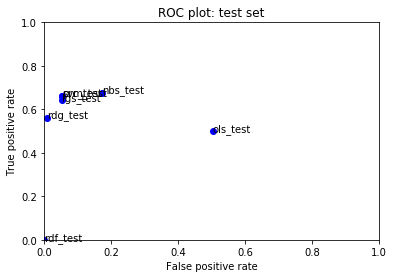

In [51]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [52]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='data/toxiccomments_test.csv', my_random_seed=70, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0          72          10
1          13           1
2          16           0
3          38           3
4           7           1
5          16           2
6          31           4
7           6       

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [53]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = prc.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.21226920164007207


In [54]:
raw_data.head()

,id,comment_text,word_count,punc_count
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,10
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,13,1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",16,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,3
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,1


In [55]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,False
2,00013b17ad220c46,False
3,00017563c3f7919a,False
4,00017695ad8997eb,False


In [56]:
my_submission.shape

(153164, 2)

In [57]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('data/toxiccomments_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation